In [75]:
import os
import arcpy
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from arcpy import env
from arcpy.management import AddSpatialJoin

In [73]:
# 设置plt支持中文显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 'Microsoft YaHei' 也是一个不错的选择
matplotlib.rcParams['axes.unicode_minus'] = False  # 正确显示负号

In [38]:
# 辅助函数
# 添加空间连接
def add_spatial_join(in_fc, join_fc):
    return arcpy.management.AddSpatialJoin(target_features=in_fc, join_features=join_fc, join_operation="JOIN_ONE_TO_ONE", join_type="KEEP_ALL", match_option="INTERSECT")
# 查看属性表
def view_attribute_table(in_fc):
    pass
# 获取要素的字段
def get_fields(in_fc):
    fields = arcpy.ListFields(in_fc)
    filds_name_list = [field.name for field in fields]
    return filds_name_list


In [39]:
# 文件路径
check_point_path = r'D:\ArcGISProjects\workspace\shbyq\features_data_vector.gdb\features_dy\dy_check_point'
check_polygon_path = r'D:\ArcGISProjects\workspace\shbyq\soil_type_result.gdb\soiltype_dy\prediction_sioltype_RandomForestEntr_20240226_reclass_smooth'
env_work_path = os.path.dirname(check_polygon_path)

In [40]:
env.workspace = env_work_path

In [41]:
print(get_fields(check_point_path))

['OBJECTID_1', 'Shape', 'OBJECTID', '名称', '土种编号', '序号', '土类', '亚类', '土属', '土种', '土种编号_1', '自然土']


In [42]:
temp_point= add_spatial_join(check_point_path, check_polygon_path)

In [45]:
temp_fields_list = get_fields(temp_point)

In [51]:
print(temp_fields_list)

['dy_check_point.OBJECTID_1', 'dy_check_point.Shape', 'dy_check_point.OBJECTID', 'dy_check_point.名称', 'dy_check_point.土种编号', 'dy_check_point.序号', 'dy_check_point.土类', 'dy_check_point.亚类', 'dy_check_point.土属', 'dy_check_point.土种', 'dy_check_point.土种编号_1', 'dy_check_point.自然土', '_AddSpatialJoin_5.OBJECTID', '_AddSpatialJoin_5.Join_Count', '_AddSpatialJoin_5.TARGET_FID', '_AddSpatialJoin_5.Id', '_AddSpatialJoin_5.gridcode', '_AddSpatialJoin_5.TL', '_AddSpatialJoin_5.YL', '_AddSpatialJoin_5.TS', '_AddSpatialJoin_5.TZ']


In [61]:
df = pd.DataFrame(arcpy.da.TableToNumPyArray(temp_point, temp_fields_list[3:],null_value=0)) 

In [62]:
df.columns

Index(['dy_check_point.名称', 'dy_check_point.土种编号', 'dy_check_point.序号',
       'dy_check_point.土类', 'dy_check_point.亚类', 'dy_check_point.土属',
       'dy_check_point.土种', 'dy_check_point.土种编号_1', 'dy_check_point.自然土',
       '_AddSpatialJoin_5.OBJECTID', '_AddSpatialJoin_5.Join_Count',
       '_AddSpatialJoin_5.TARGET_FID', '_AddSpatialJoin_5.Id',
       '_AddSpatialJoin_5.gridcode', '_AddSpatialJoin_5.TL',
       '_AddSpatialJoin_5.YL', '_AddSpatialJoin_5.TS', '_AddSpatialJoin_5.TZ'],
      dtype='object')

In [63]:
# 修改列名称，去掉点（.）以前的字符串
df.columns = [col.split('.')[-1] for col in df.columns]

# 打印修改后的列名称
print(df.columns)

Index(['名称', '土种编号', '序号', '土类', '亚类', '土属', '土种', '土种编号_1', '自然土', 'OBJECTID',
       'Join_Count', 'TARGET_FID', 'Id', 'gridcode', 'TL', 'YL', 'TS', 'TZ'],
      dtype='object')


In [64]:
df = df.drop(columns=[_ for _ in df.columns if _.upper() not in ['土类','亚类','土属','土种','TL','YL','TS','TZ']])

In [66]:
df.columns = ['true_tl','true_yl','true_ts','true_tz','pred_tl', 'pred_yl', 'pred_ts', 'pred_tz']

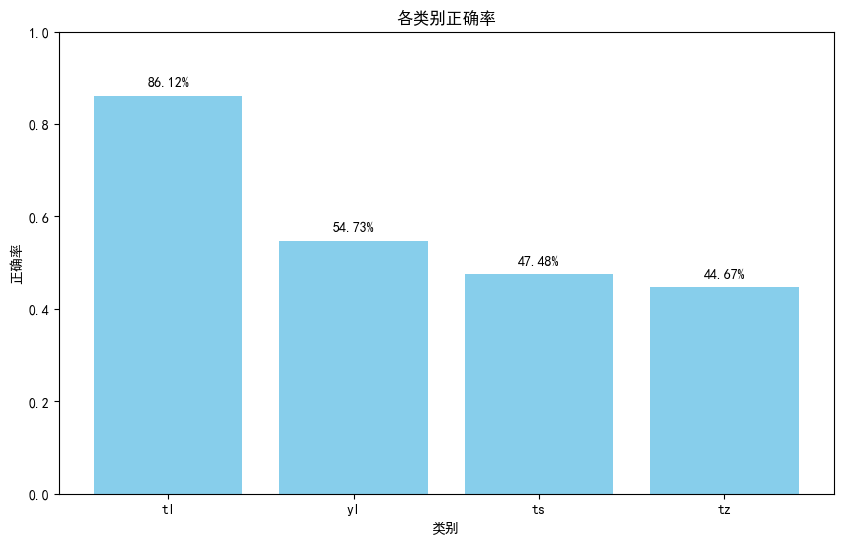

In [74]:
# 计算正确率
categories = ['tl', 'yl', 'ts', 'tz']  # 类别列表
accuracy_results = {}

for cat in categories:
    true_col = f'true_{cat}'
    pre_col = f'pred_{cat}'
    correct_predictions = (df[true_col] == df[pre_col]).sum()  # 计算匹配数量
    accuracy = correct_predictions / len(df)  # 计算正确率
    accuracy_results[cat] = accuracy

# 类别列表
categories = list(accuracy_results.keys())
# 对应的正确率
accuracies = [accuracy_results[cat] for cat in categories]

# 创建条形图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.bar(categories, accuracies, color='skyblue')  # 绘制条形图
plt.xlabel('类别')  # 设置x轴标签
plt.ylabel('正确率')  # 设置y轴标签
plt.title('各类别正确率')  # 设置图形标题
plt.ylim(0, 1)  # 设置y轴的范围

# 在每个条形上显示正确率的具体值
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.2%}', ha='center')

# 显示图形
plt.show()

类别 tl 的详细准确率分析：
值 黄壤 的准确率为: 74.51%
值 水稻土 的准确率为: 100.00%
值 石灰土 的准确率为: 15.22%
值 紫色土 的准确率为: 25.00%
值 山地灌丛草甸土 的准确率为: 0.00%


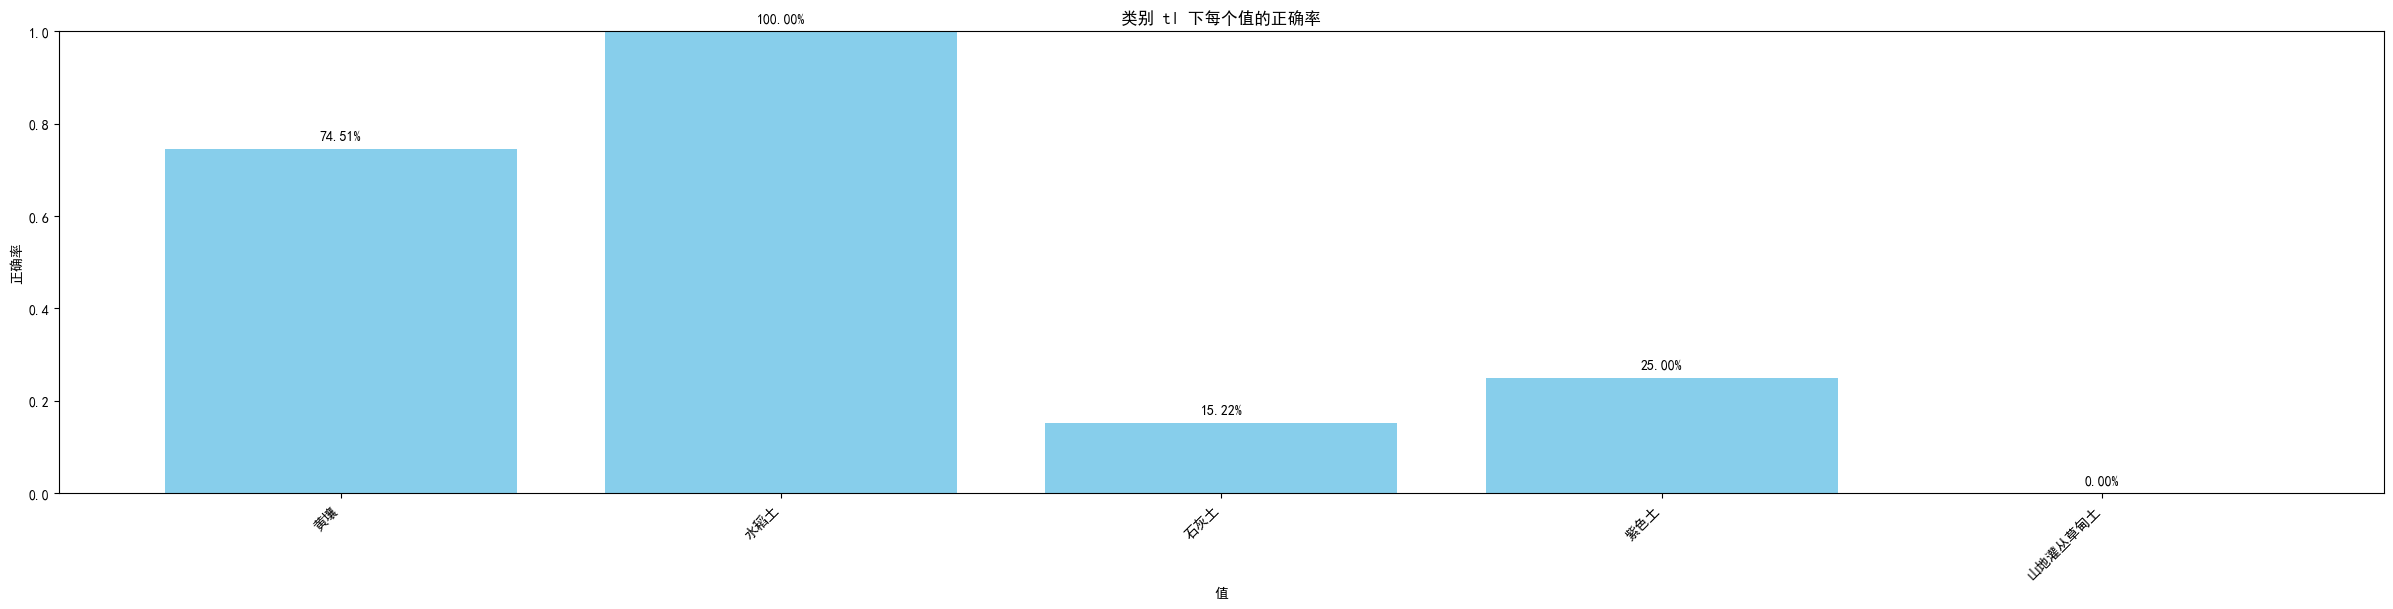

---
类别 yl 的详细准确率分析：
值 黄泥土 的准确率为: 11.11%
值 淹育型水稻土 的准确率为: 78.69%
值 黄色石灰土 的准确率为: 33.33%
值 黄壤 的准确率为: 57.14%
值 潴育型水稻土 的准确率为: 76.29%
值 大土泥 的准确率为: 6.98%
值 紫泥土 的准确率为: 0.00%
值 潜育型水稻土 的准确率为: 6.25%
值 山地灌丛草甸土 的准确率为: 0.00%
值 侧渗型水稻土 的准确率为: 0.00%
值 沼泽型水稻土 的准确率为: 16.67%
值 钙质性宁性紫色土 的准确率为: 100.00%


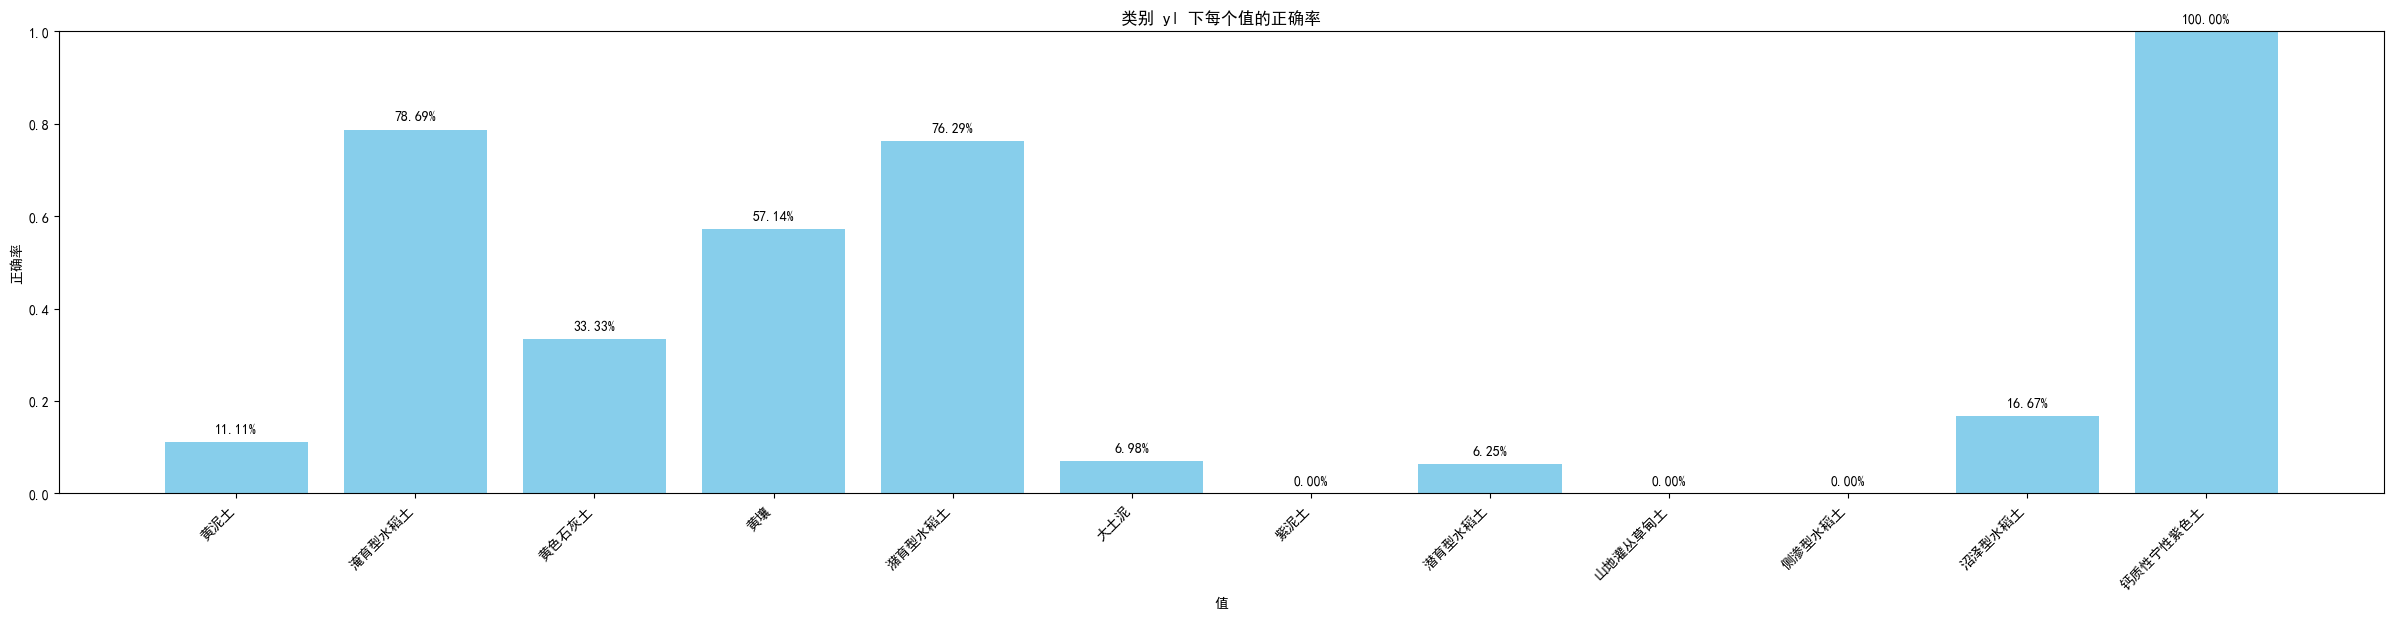

---
类别 ts 的详细准确率分析：
值 黄泥土 的准确率为: 10.87%
值 淹育型石灰性大泥田APC 的准确率为: 39.13%
值 黄色石灰土 的准确率为: 33.33%
值 硅质黄壤 的准确率为: 14.29%
值 黄沙泥土 的准确率为: 17.65%
值 潴育型黄泥田APWC或APBC 的准确率为: 38.46%
值 潴育型潮泥田APWC或APWG 的准确率为: 60.94%
值 潴育型石灰性大眼泥田ARWC或APBC 的准确率为: 68.93%
值 大土泥 的准确率为: 4.35%
值 小泥土 的准确率为: 11.11%
值 淹育型黄泥田AC或APC 的准确率为: 83.51%
值 石砂土 的准确率为: 6.25%
值 紫沙土 的准确率为: 0.00%
值 冷水田 的准确率为: 0.00%
值 鸭屎泥潜育型石灰性草甸沼泽水稻土APGC或APG 的准确率为: 7.69%
值 硅铝质黄壤 的准确率为: 71.43%
值 胶泥土 的准确率为: 0.00%
值 山地灌丛草甸土 的准确率为: 0.00%
值 铁铝质黄壤 的准确率为: 50.00%
值 淹育型潮沙田 的准确率为: 0.00%
值 白沙土 的准确率为: 0.00%
值 白胶泥田A—P E—E(C) 的准确率为: 0.00%
值 烂泥田AG或AG-G 的准确率为: 16.67%
值 白泥田A—P E—E(C)或A—P—E(C) 的准确率为: 0.00%
值 紫泥土 的准确率为: 0.00%
值 硅铁质黄壤 的准确率为: 60.00%
值 冷浸田APG或APWC 的准确率为: 0.00%
值 砾质紫沙土 的准确率为: 0.00%
值 紫色土 的准确率为: 100.00%


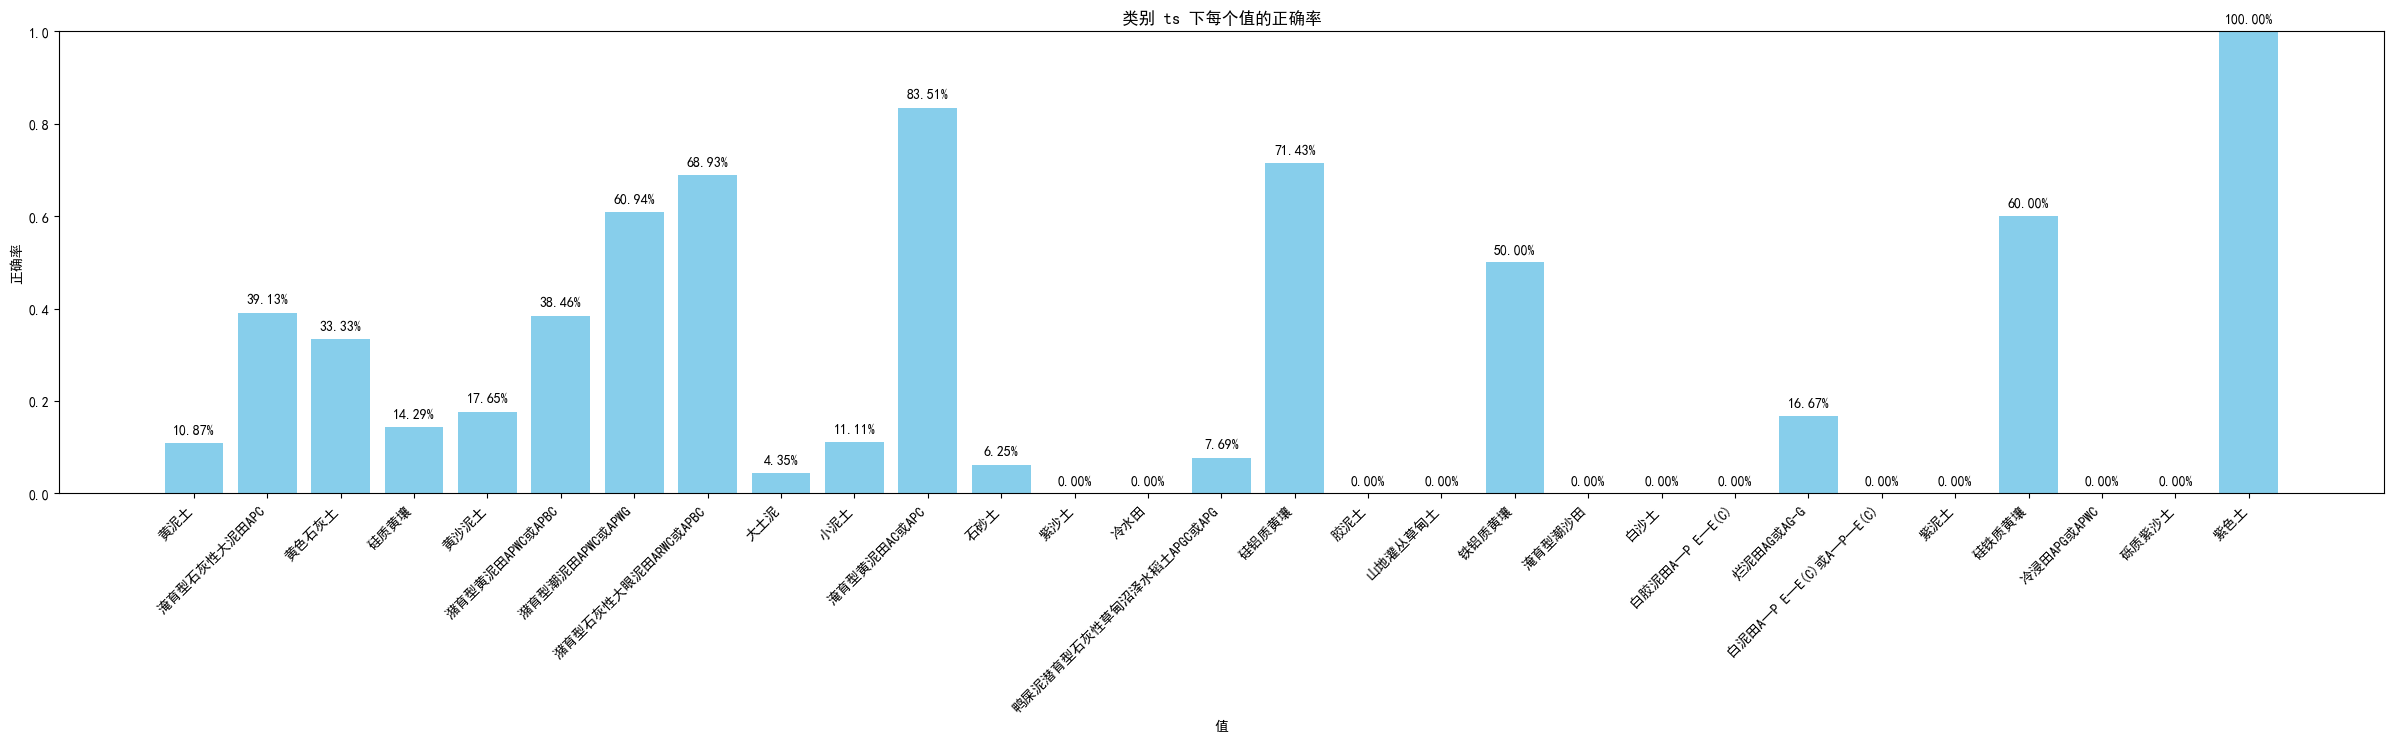

---
类别 tz 的详细准确率分析：
值 黄泥土 的准确率为: 11.90%
值 黄大泥田 的准确率为: 50.00%
值 薄腐殖层薄土层黄色石灰土 的准确率为: 0.00%
值 厚腐殖层薄土层硅质黄壤 的准确率为: 25.00%
值 黄沙泥土 的准确率为: 17.65%
值 黄泥田 的准确率为: 44.44%
值 潮泥田 的准确率为: 80.00%
值 大眼泥田 的准确率为: 60.00%
值 大泥土 的准确率为: 4.55%
值 小泥土 的准确率为: 11.11%
值 黄沙泥田 的准确率为: 84.09%
值 偏沙土 的准确率为: 0.00%
值 潮沙泥田 的准确率为: 58.33%
值 紫沙土 的准确率为: 0.00%
值 黄油沙泥田 的准确率为: 0.00%
值 冷水田 的准确率为: 0.00%
值 大眼黄泥田 的准确率为: 69.35%
值 干鸭屎泥田 的准确率为: 11.11%
值 薄腐殖层厚土层硅铝质黄壤 的准确率为: 75.00%
值 潮油沙泥田 的准确率为: 66.67%
值 黑潮泥田 的准确率为: 0.00%
值 小黄泥土 的准确率为: 0.00%
值 石碴子土 的准确率为: 50.00%
值 黄胶泥土 的准确率为: 0.00%
值 薄腐殖薄土层山地灌丛草甸土 的准确率为: 0.00%
值 薄腐殖层薄土层铁铝质黄壤 的准确率为: 0.00%
值 大泥田 的准确率为: 0.00%
值 薄腐殖层中土层铁铝质黄壤 的准确率为: 100.00%
值 潮板沙田 的准确率为: 0.00%
值 潮沙田 的准确率为: 40.00%
值 死黄泥田 的准确率为: 0.00%
值 苦大泥田 的准确率为: 0.00%
值 白云沙土 的准确率为: 0.00%
值 熟鸭屎泥田 的准确率为: 0.00%
值 黄胶泥田 的准确率为: 25.00%
值 重白胶泥田 的准确率为: 0.00%
值 薄腐殖层厚土层硅质黄壤 的准确率为: 0.00%
值 浅足烂泥田 的准确率为: 20.00%
值 中白鳝泥田 的准确率为: 0.00%
值 白沙泥田 的准确率为: 0.00%
值 冷沙土 的准确率为: 0.00%
值 湿鸭屎泥田 的准确率为: 0.00%
值 小黄泥田 的准确率为: 0.00%
值 紫色土 的准确率为: 0.00%
值 火石沙土 的准确率为: 0.00%
值 深足烂泥田 

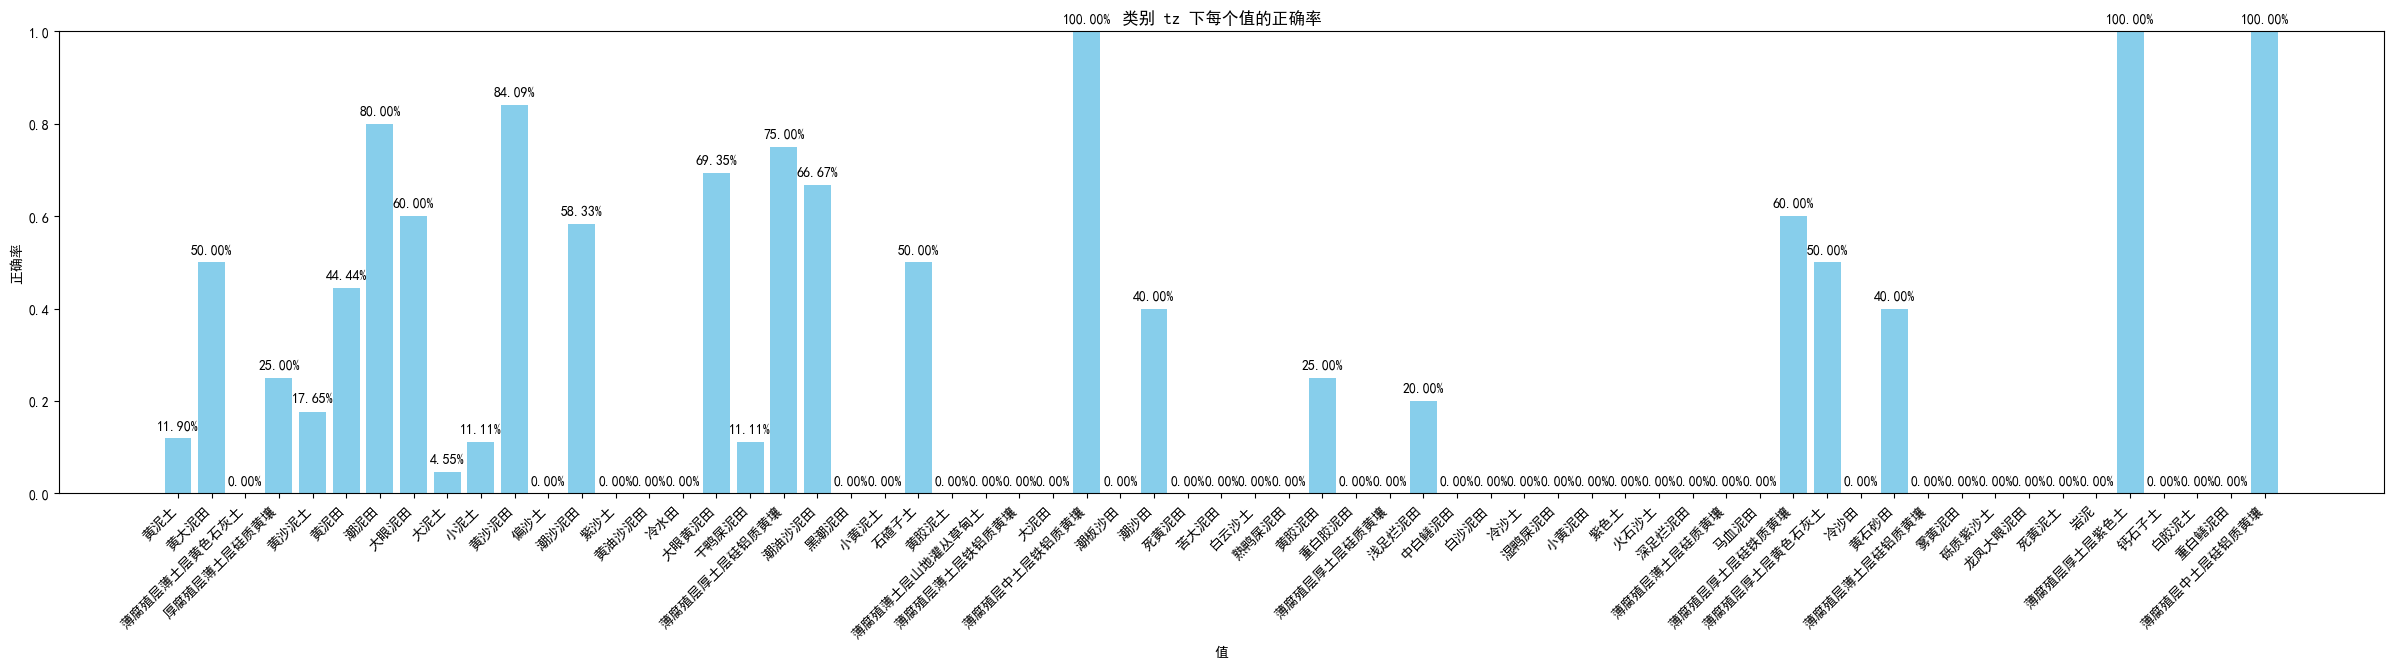

---


In [85]:


# 分析每个类别下每个值的准确率
categories = ['tl', 'yl', 'ts', 'tz']  # 类别列表
def plot_bar_chart(category, values, accuracies):
    plt.figure(figsize=(30, 6))  # 设置图形大小
    plt.bar(values, accuracies, color='skyblue')  # 绘制条形图
    plt.xlabel('值')  # 设置x轴标签
    plt.ylabel('正确率')  # 设置y轴标签
    plt.title(f'类别 {category} 下每个值的正确率')  # 设置图形标题
    plt.ylim(0, 1)  # 设置y轴的范围
    # 在每个条形上显示正确率的具体值
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f'{acc:.2%}', ha='center', color='black')
    # X轴标签显示格式
    plt.xticks(rotation=45, ha="right")
    # 显示图形
    plt.show()
# 分析每个类别下每个值的准确率并绘制柱状图
for cat in categories:
    true_col = f'true_{cat}'
    pre_col = f'pred_{cat}'
    unique_values = df[true_col].unique()  # 获取该类别下的所有唯一值
    accuracies = []
    print(f'类别 {cat} 的详细准确率分析：')
    for val in unique_values:
        total_val_count = (df[true_col] == val).sum()  # 真实值中该值的总数量
        correct_val_predictions = ((df[true_col] == df[pre_col]) & (df[true_col] == val)).sum()  # 正确预测的数量
        if total_val_count > 0:  # 避免除以零
            accuracy = correct_val_predictions / total_val_count
            accuracies.append(accuracy)
            print(f'值 {val} 的准确率为: {accuracy:.2%}')
        else:
            print(f'值 {val} 的准确率无法计算，因为没有这个值的真实实例。')
            accuracies.append(0)  # 添加一个0作为准确率，以便在柱状图中表示
    # 绘制柱状图
    plot_bar_chart(cat, unique_values, accuracies)

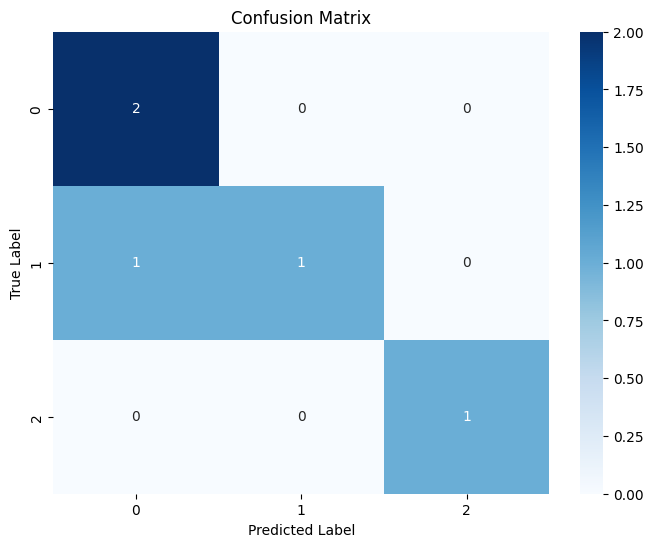

In [2]:
# 假设 y_true 和 y_pred 是您的真实标签和预测标签
y_true = [1, 0, 2, 1, 0]  # 示例真实标签
y_pred = [1, 0, 2, 0, 0]  # 示例预测标签

# 计算混淆矩阵
conf_mat = confusion_matrix(y_true, y_pred)

# 使用Seaborn绘制混淆矩阵
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()